In [43]:
import numpy as np
import pandas as pd
import pingouin
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import networkx as nx
from netgraph import Graph
import matplotlib as mpl
from model_equ import *
from model_dynamic import *
from analysis_help import *
smallfs = 7
bigfs = 9
supersmallfs =6
plt.rcParams.update({"font.size":bigfs})

In [44]:
countryXdataset = {"gesis":"Germany", "liss":"Netherlands", "autnes":"Austria"}
atts_datasets = {
    "gesis": ["econ", "migr", "assim", "clim", "euro", "femin"],
    "liss": ["euth", "inequ", "migrAss", "eu", "nr_mig", "asyl"],
    "autnes":[]
}
partiesDict = {
    "Germany": ["Linke", "Grüne", "SPD", "FDP", "CDU/CSU", "AfD", "none"],
    "Netherlands": ["far left", "centre left", "centre", "centre right", "far right", "none"],
    "Austria": ["Grüne", "SPÖ", "NEOS", "ÖVP", "FPÖ", "none"]
}
partyColsDict = {
    "Austria": dict(zip( ["Grüne", "SPÖ", "NEOS", "ÖVP", "FPÖ", "none", "other"] , [(146/255,208/255,80/255), (1,0,0), (232/255, 65/255, 136/255), (0,0,0), (0/255, 102/255, 255/255) , "grey"])),
    "Germany":dict(zip(["CDU/CSU", "SPD", "Linke", "Grüne", "FDP", "AfD", "none", "other"], ["#000000", "#E3000F", "#b61c3e", "#1AA037", "#FFEF00", "#0489DB", "grey", "grey"]))  , 
    "Netherlands":  dict(zip(["far left", "centre left", "centre", "centre right", "far right", "none", "other"], ["pink", "red", "darkgreen", "k", "darkblue", "grey", "grey"])),
}

yearsXdatasetXwaves = {
    "liss":{ "m-p":"2021-2024", "h-l":"2016-2020"},
    "gesis": {"1-19":"20216-2021", "20-27":"2021-2024"}
    
}


In [45]:
folder = "../../opinion-data-curation/data/clean/"
simOut = {}
datasets = ["gesis", "liss"]
influence_type = ["correlation", "co-occurence", "copy"]
waves = {
        "gesis":["1-19", "20-27"],
        "liss":["h-l", "m-p"]
    }
#i ="co-occurence"
#n = "observe-neighbours"
indegree = 10
outdegree = 0
#n += f"(Stoch-Block-{indegree}-{outdegree})" if "neighbours" in n else ""
NetworkTypes =  [ "observe-neighbours"+ f"(Stoch-Block-{indegree}-{outdegree})"] #, "observe-all"]
InfluenceTypes = ["copy"]#, "co-occurence"], 
n_ag = 2000
seed = 1
paramCombis = [(eps, mu, lam, i,n, n_ag, seed) for i in InfluenceTypes for eps, mu, lam in [(0.0, 0.2,0.05), (0.4, 0.0, 0.05), (0.4, 0.2, 0.05)] for n in NetworkTypes]  
for dataset in datasets:
    country = countryXdataset[dataset]
    atts = atts_datasets[dataset]
    edgeNamesTuple = [f"({i},{j})" for i,j in list(combinations(atts, 2))]
    edgeNames = [f"{e.split(',')[0][1:]}↔{e.split(",")[1][:-1]}" for e in edgeNamesTuple]
    for eps, mu, lam, i, n, n_ag, seed in paramCombis:
        for wave in waves[dataset]:
            filename = f"results/inferBNs-dynamic_{dataset.lower()}-n-{n_ag}_{i}-{n}_{wave}-{country}_eps{eps}_mu{mu}_lam{lam}_seed{seed}"
            # equilibrium: f"results/inferBNs-equilibrium_{i}_{dataset}{wave}-{country}_eps{eps}_mu{mu}_lam{lam}.csv"
            simOut[(eps, mu, lam, i, n, n_ag, dataset, country, wave, seed)] = pd.read_csv(filename+".csv")
for k in simOut.keys(): print(k)

(0.0, 0.2, 0.05, 'copy', 'observe-neighbours(Stoch-Block-10-0)', 2000, 'gesis', 'Germany', '1-19', 1)
(0.0, 0.2, 0.05, 'copy', 'observe-neighbours(Stoch-Block-10-0)', 2000, 'gesis', 'Germany', '20-27', 1)
(0.4, 0.0, 0.05, 'copy', 'observe-neighbours(Stoch-Block-10-0)', 2000, 'gesis', 'Germany', '1-19', 1)
(0.4, 0.0, 0.05, 'copy', 'observe-neighbours(Stoch-Block-10-0)', 2000, 'gesis', 'Germany', '20-27', 1)
(0.4, 0.2, 0.05, 'copy', 'observe-neighbours(Stoch-Block-10-0)', 2000, 'gesis', 'Germany', '1-19', 1)
(0.4, 0.2, 0.05, 'copy', 'observe-neighbours(Stoch-Block-10-0)', 2000, 'gesis', 'Germany', '20-27', 1)
(0.0, 0.2, 0.05, 'copy', 'observe-neighbours(Stoch-Block-10-0)', 2000, 'liss', 'Netherlands', 'h-l', 1)
(0.0, 0.2, 0.05, 'copy', 'observe-neighbours(Stoch-Block-10-0)', 2000, 'liss', 'Netherlands', 'm-p', 1)
(0.4, 0.0, 0.05, 'copy', 'observe-neighbours(Stoch-Block-10-0)', 2000, 'liss', 'Netherlands', 'h-l', 1)
(0.4, 0.0, 0.05, 'copy', 'observe-neighbours(Stoch-Block-10-0)', 2000, 'l

# Plot the Beliefs

In [51]:
infl = "copy"
n = "observe-neighbours(Stoch-Block-10-0)"
n_ag = 2000
dataset = "liss"
atts = atts_datasets[dataset]
country = countryXdataset[dataset]
eps, mu, lam = (0.4, 0.2, 0.05)


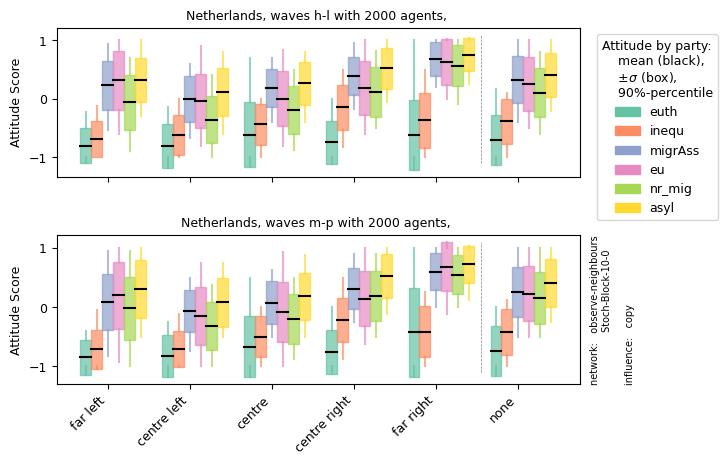

In [52]:
fig, axs = plt.subplots(2,1, figsize=(19/2.54, 12/2.54), sharex=True)
for ax, w in zip(axs, waves[dataset]):
    df = simOut[(eps, mu, lam, infl, n, n_ag, dataset, country, w, seed)]# Melt the DataFrame to long format
    df_melted = df.melt(id_vars="identity", value_vars=atts,
                        var_name='attitude', value_name='value')


    ax, leg = custom_boxplot_mean(data=df_melted, x="identity", y="value", hue='attitude', palette='Set2', dodge=True, order=parties[country], ax=ax, legend=True if ax==axs[0] else False, tot_width=0.8)

    # Add title and labels
    ax.set_title(f'{country}, waves {w} with {n_ag} agents, ', fontsize=bigfs)
    ax.set_xlabel("")
    #if ax==axs[0]: ax.set_xlabel('Identity Group')
    ax.set_ylabel('Attitude Score')
    if ax==axs[1] and not "all" in n: ax.text(1.02, 1, f"network:   {n.split('(')[0]}\n                 {n.split('(')[1][:-1]}"+"\n\n"+f"influence:   {i}", rotation=90, ha="left", va="top", transform=ax.transAxes, fontsize=smallfs)
    if leg is not None:
        leg.set_title("Attitude by party:\n    mean (black),\n"+r"    $\pm\sigma$ (box)"+",\n    90%-percentile",)
    ax.vlines(len(partiesDict[country])-2+0.55, -1.1, 1.1, linestyles="--", colors="grey", lw=0.5)
    #if ax==axs[0]: ax.legend(title='Attitude', bbox_to_anchor=(1.02, 1), loc='upper left')
fig.tight_layout()
plt.show()


In [53]:
before = simOut[(eps, mu, lam, i, n, n_ag, dataset, country, waves[dataset][0], seed)]
before = before.set_index("index")
after = simOut[(eps, mu, lam, i, n, n_ag, dataset, country, waves[dataset][1], seed)]
after = after.set_index("index")
participation_df = pd.DataFrame(index=range(max(before.index.astype(int).max(), after.index.astype(int).max())+1))
participation_df.loc[before.index, waves[dataset][0]] = 1
participation_df.loc[after.index, waves[dataset][1]] = 1
participation_df["both"] = participation_df[waves[dataset][0]] * participation_df[waves[dataset][1]]
indices_before_after = list(participation_df.loc[participation_df.both==1].index)


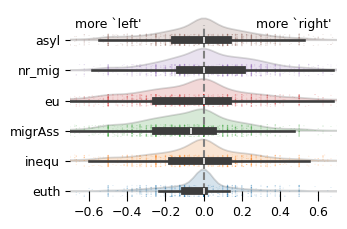

In [54]:
# fig, ax = plt.subplots(1,1, figsize=(9/2.54, 5/2.54))
# sns.violinplot(((after.loc[indices_before_after][atts]- before.loc[indices_before_after][atts] ).clip(-1,1)), orient="h", ax=ax, split=False,gap=-0.8, clip_on=True)#, clip=(-1,1))
# ax.set_xlim(-0.5,0.5)
# for violin in ax.collections[::]:  # Select only the violin bodies
#     paths = violin.get_paths()
#     for path in paths:
#         verts = path.vertices
#         verts[:, 1] = np.clip(verts[:, 1], verts[:, 1].mean(), None)  # Keep top half only
# ax.set_ylim(-0.2, len(atts))
# ax.vlines(0,-0.5,len(atts)-1, linestyles="--", colors="grey", zorder=1)
# ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
# for sp in ax.spines:
#     ax.spines[sp].set_visible(False)
# ax.spines['bottom'].set_position(("data", 0))
# #ax.set_title(f"belief change between waves {waves[0]} vs. {waves[1]} (n={len(after.loc[indices_before_after])})")
# ax.text(0.02,0.98, "more `left'", va="top", ha="left", transform=ax.transAxes)
# ax.text(0.98,0.98, "more `right'", va="top", ha="right", transform=ax.transAxes)
# #plt.savefig(f"figs_panelLISS/beliefchange_waves{waves[0]}-{waves[1]}_{dataset}_eps{eps}_mu{mu}_lam{lam}.png")
# 
# 
fig, ax = plt.subplots(1,1, figsize=(9/2.54, 6/2.54))
sns.stripplot((after.loc[indices_before_after][atts]- before.loc[indices_before_after][atts] ), orient="h",  size=1, jitter=0.2, alpha=0.2, ax=ax, zorder=0)#, clip=(-1,1))

sns.violinplot(((after.loc[indices_before_after][atts]- before.loc[indices_before_after][atts] ).clip(-1,1)), orient="h", ax=ax, alpha=0.2,split=False,gap=-0.8, clip_on=True)#, clip=(-1,1))
ax.set_xlim(-0.7,0.7)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
for violin in ax.collections[::]:  # Select only the violin bodies
    paths = violin.get_paths()
    for path in paths:
        verts = path.vertices
        verts[:, 1] = np.clip(verts[:, 1], verts[:, 1].mean(), None)  # Keep top half only
    
#ax.set_title(f"no bias in belief change\nbetween 16-21 (waves {waves[0]}) vs. 21-24 ({waves[1]}; n={len(after.loc[indices_before_after])})", fontsize=15)
ax.set_ylim(-0.2, len(atts))
ax.vlines(0,-0,len(atts)-0.5, linestyles="--", colors="grey", zorder=1)
ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
for sp in ax.spines:
    ax.spines[sp].set_visible(False)
ax.spines['bottom'].set_position(("data", 0))
ax.xaxis.set_tick_params(which="major", length=7)

ax.text(0.02,0.96, "more `left'", va="top", ha="left", transform=ax.transAxes)
ax.text(0.98,0.96, "more `right'", va="top", ha="right", transform=ax.transAxes)
fig.tight_layout()
#plt.savefig(f"figs_panelLISS/beliefchange_waves{waves[0]}-{waves[1]}_LISS+data_eps{eps}_mu{mu}_lam{lam}.png", dpi=600)
plt.savefig("testfigs/nodes.png", dpi=600)

# Plot edges

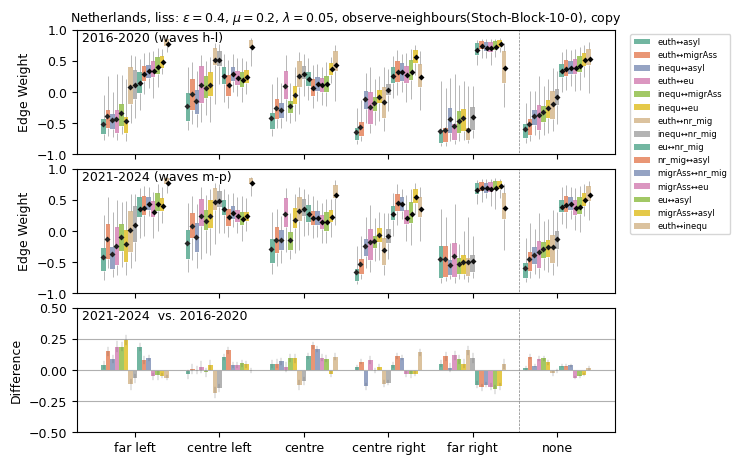

In [55]:

before = simOut[(eps, mu, lam, infl, n, n_ag, dataset, country, waves[dataset][0], seed)].set_index("index")
after = simOut[(eps, mu, lam, infl, n, n_ag, dataset, country, waves[dataset][1], seed)].set_index("index").loc[before.index]


fig, axs = plt.subplots(3,1, figsize=(19/2.54, 12/2.54), sharex=True, sharey=False)
for ax, w, df in zip(axs, waves[dataset], [before, after]):
    # Melt the DataFrame to long format
    edgeNamesTuple = [f"({i},{j})" for i,j in list(combinations(atts_datasets[dataset], 2))]
    df = df.rename(columns=dict(zip(edgeNamesTuple, edgeNames)))
    df_melted = df.melt(id_vars="identity", value_vars=edgeNames,
                        var_name='edge weight', value_name='value')
    if ax==axs[0]:
        hue_order = list(df_melted.groupby(["identity", "edge weight"])["value"].mean()["none"].sort_values().keys())
    sns.boxplot(data=df_melted, x='identity', y='value', hue='edge weight', hue_order= hue_order,
                palette='Set2', dodge=True,  whis=[5,95], fliersize=0, order=parties[country], ax=ax, legend=True if ax==axs[0] else False, linewidth=0.5,capprops=dict(visible=False),whiskerprops=dict(linewidth=0.4, color="grey"), boxprops=dict(linewidth=0, ),medianprops=dict(lw=0),)
    sns.pointplot(
        data=df_melted,
        x='identity', y='value', hue='edge weight', hue_order=hue_order,
        estimator='mean', dodge=0.77, linestyles="", markers='D', palette="dark:black", errorbar=None, ax=ax, legend=False,  order=parties[country], markersize=1, 
    )

    # Add title and labels
    ax.text(0.01,0.99, f'{yearsXdatasetXwaves[dataset][w]} (waves {w})', ha="left", va="top", transform=ax.transAxes)
    ax.set_xlabel('')
    ax.set_ylabel('Edge Weight')
    ax.set_ylim(-1,1)
    if ax==axs[0]:
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=supersmallfs, ncol=1)


df = after[edgeNamesTuple] - before[edgeNamesTuple]
df["identity"] = before["identity"]

# Melt the DataFrame to long format

df = df.rename(columns=dict(zip(edgeNamesTuple, edgeNames)))
df_melted = df.melt(id_vars="identity", value_vars=edgeNames,
                        var_name='edge weight', value_name='value')
#sns.boxplot(data=df_melted, x='identity', y='value', hue='edge weight', hue_order= hue_order, palette='Set2', dodge=True,  whis=[5,95], fliersize=0, order=parties[country], ax=axs[2], legend=False, linewidth=0.5,capprops=dict(visible=False),whiskerprops=dict(linewidth=0.4, color="grey"), boxprops=dict(linewidth=0, ),medianprops=dict(lw=0),)

sns.barplot(
        data=df_melted,
        x='identity', y='value', hue='edge weight', hue_order=hue_order,
        estimator='mean', dodge=0.77, palette="Set2",ax=axs[2], legend=False,  order=parties[country],   err_kws={"lw":0.2} )

# Add title and labels
axs[2].text(0.01,0.99, f'{yearsXdatasetXwaves[dataset][waves[dataset][1]]}  vs. {yearsXdatasetXwaves[dataset][waves[dataset][0]]}', ha="left", va="top", transform=axs[2].transAxes)
axs[2].set_xlabel('')
axs[2].set_ylabel('Difference')
axs[2].set_ylim(-0.5,0.5)
axs[2].grid(axis="y")
axs[0].set_title(fr"{country}, {dataset}: $\epsilon={eps}$, $\mu={mu}$, $\lambda={lam}$, {n}, {infl}", fontsize=bigfs)

for ax in axs:
    ax.vlines(len(partiesDict[country])-2+0.55, -1.1, 1.1, linestyles="--", colors="grey", lw=0.5)

fig.tight_layout(h_pad=-7)
plt.savefig("testfigs/edges.png", dpi=600)

In [56]:
after.identity.replace({np.nan:-1}).value_counts()

identity
none            735
centre right    458
centre left     240
centre          172
far left        150
-1              143
far right       102
Name: count, dtype: int64

In [57]:
df

euth↔inequ  euth↔migrAss   euth↔eu  euth↔nr_mig  euth↔asyl  \
index                                                                  
853887.0   -0.214613     -0.380368 -0.063656    -0.736582  -0.107297   
890808.0    0.046443      0.416272 -0.035971     0.092534   0.131573   
866027.0   -0.027181      0.474288  0.183860     0.060255   0.367859   
815219.0   -0.472381      0.177017  0.090861    -0.128747  -0.050214   
810284.0   -0.116251     -0.220489 -0.061051    -0.501466  -0.190702   
...              ...           ...       ...          ...        ...   
871617.0    0.042009      0.054381  0.156733     0.014264   0.203263   
804284.0    0.018396     -0.052370 -0.041877     0.055261  -0.045651   
889430.0   -0.146974      0.259223  0.132647     0.021743   0.108630   
833993.0   -0.335240      0.009089  0.050906    -0.144799  -0.017315   
831235.0    0.095507      0.253512 -0.196397    -0.438483  -0.037699   

          inequ↔migrAss  inequ↔eu  inequ↔nr_mig  inequ↔asyl  migrAss↔eu  \
index                                                                     
853887.0       0.278733  0.464981      0.030078    0.445616    0.220172   
890808.0       0.477459 -0.057851     -0.077920   -0.031405   -0.408309   
866027.0       0.487498  0.104681      0.148397    0.252357   -0.117886   
815219.0       0.456968  0.609803      0.515213    0.422867    0.312932   
810284.0      -0.087298  0.280773      0.057580   -0.097033   -0.007139   
...                 ...       ...           ...         ...         ...   
871617.0       0.163749  0.187954      0.225200    0.242133   -0.000490   
804284.0       0.107443  0.082309      0.072752   -0.007724    0.105115   
889430.0       0.331223  0.162723      0.200033    0.351423   -0.120913   
833993.0      -0.002356 -0.153157     -0.093732   -0.169622    0.070532   
831235.0       0.363857 -0.034086     -0.752725    0.038976    0.018175   

          migrAss↔nr_mig  migrAss↔asyl  eu↔nr_mig   eu↔asyl  nr_mig↔asyl  \
index                                                                      
853887.0        0.371792      0.226746   0.438647  0.237580     0.324121   
890808.0        0.040596      0.079551  -0.004992 -0.294385    -0.076537   
866027.0       -0.032758     -0.065051   0.040250  0.062443     0.025976   
815219.0        0.037673      0.092764   0.145364  0.048626    -0.043754   
810284.0        0.000475      0.041627   0.222446 -0.037882     0.128247   
...                  ...           ...        ...       ...          ...   
871617.0        0.057519      0.525066   0.021289  0.554194     0.558948   
804284.0       -0.041064      0.065816   0.127945  0.106230     0.045000   
889430.0       -0.078940     -0.185232   0.197130  0.082391     0.275077   
833993.0        0.085791     -0.001715  -0.021296 -0.055882    -0.049351   
831235.0        0.889167     -0.479983  -0.084966  0.137172     0.878975   

          identity  
index               
853887.0  far left  
890808.0  far left  
866027.0  far left  
815219.0  far left  
810284.0  far left  
...            ...  
871617.0       NaN  
804284.0       NaN  
889430.0       NaN  
833993.0       NaN  
831235.0       NaN  

[2000 rows x 16 columns]

In [23]:
before.loc[before.identity=="far right"][edgeNamesTuple].mean(axis=0)


(euth,inequ)        0.386981
(euth,migrAss)     -0.614564
(euth,eu)          -0.549907
(euth,nr_mig)      -0.606950
(euth,asyl)        -0.630883
(inequ,migrAss)    -0.458164
(inequ,eu)         -0.414724
(inequ,nr_mig)     -0.397447
(inequ,asyl)       -0.435487
(migrAss,eu)        0.701587
(migrAss,nr_mig)    0.715045
(migrAss,asyl)      0.776053
(eu,nr_mig)         0.668613
(eu,asyl)           0.725481
(nr_mig,asyl)       0.743121
dtype: float64

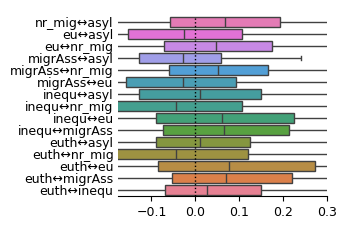

In [24]:
fig, ax = plt.subplots(1,1, figsize=(9/2.54, 6/2.54))
#sns.violinplot(((after.loc[indices_before_after][edgeNames]- before.loc[indices_before_after][edgeNames] ).rename(columns=shortcutEdges).clip(-1,1)), orient="h",)# clip=(-1,1))
edgeNamesTuple = [f"({i},{j})" for i,j in list(combinations(atts, 2))]
edgeNames = [f"{e.split(',')[0][1:]}↔{e.split(",")[1][:-1]}" for e in edgeNamesTuple]
sns.boxplot(((after.loc[indices_before_after][edgeNamesTuple]- before.loc[indices_before_after][edgeNamesTuple]).clip(-1,1).rename(columns=dict(zip(edgeNamesTuple, edgeNames)))), fliersize=0, whis=[5,95], orient="h",)# clip=(-1,1))

ax.set_xlim(-0.175,0.3)
ax.vlines(0,0-0.5,len(edgeNames)-0.5, linestyles=":", colors="k", lw=1,zorder=10)
ax.hlines(range(len(edgeNames)), -0.25, 0, linestyles=":", colors="grey", lw=0.5, zorder=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_ylim(-0.5,len(edgeNames))
ax.tick_params(axis="y", which="major", length=0, labelsize=bigfs)
#ax.set_xlabel(f"edge weight from 21-24 (waves {waves[1]}) vs. 16-21 (waves {waves[0]})")
#fig.subplots_adjust(left=0.12, top=0.93, right=0.99, bottom=0.12)
#ax.set_title(f"Most belief relations slightly increase between 16-21 to 21-24\n({country}; n={len(after.loc[indices_before_after])})", fontsize=12)
fig.tight_layout()

#plt.savefig(f"figs_panelLISS/beliefedgeschange_waves{waves[0]}-{waves[1]}_{i}_{dataset}_eps{eps}_mu{mu}_lam{lam}.png", dpi=600)


# Separate those with changed and constant identity 

In [58]:
eps, mu, lam = (0.4,0.2,0.05)
i = "copy"
n = "observe-neighbours(Stoch-Block-10-0)"
dataset = "gesis"
country = countryXdataset[dataset]
atts = atts_datasets[dataset]
edgeNamesTuple = [f"({i},{j})" for i,j in list(combinations(atts, 2))]


before = simOut[(eps, mu, lam, i, n, n_ag, dataset, country, waves[dataset][0], seed)].set_index("index")
after = simOut[(eps, mu, lam, i, n, n_ag, dataset, country, waves[dataset][1], seed)].set_index("index").loc[before.index]

diff = (after[edgeNamesTuple] - before[edgeNamesTuple]).abs().loc[before.index]

diff["op_change"] = ((after[atts] - before[atts]).abs()**2).loc[before.index].sum(axis=1)

diff["identity_before"] = before.loc[before.index, "identity"] 
diff["identity_after"] = after.loc[before.index, "identity"]
diff["identity_changed"] = diff["identity_before"]!=diff["identity_after"]

# frobenius network distance
diff["frobeniusD"] = (diff[edgeNamesTuple]**2).sum(axis=1)

d = diff.groupby("identity_changed")[edgeNamesTuple].mean()
display(d)
display(d.mean(axis="columns"))


(econ,migr)  (econ,assim)  (econ,clim)  (econ,euro)  \
identity_changed                                                        
False                0.173531      0.164980     0.161502     0.167849   
True                 0.201158      0.185992     0.194125     0.196490   

                  (econ,femin)  (migr,assim)  (migr,clim)  (migr,euro)  \
identity_changed                                                         
False                 0.161114      0.115310     0.196995     0.148804   
True                  0.200915      0.155492     0.247559     0.179075   

                  (migr,femin)  (assim,clim)  (assim,euro)  (assim,femin)  \
identity_changed                                                            
False                 0.184326      0.198323      0.153790       0.175327   
True                  0.224213      0.239726      0.208563       0.196433   

                  (clim,euro)  (clim,femin)  (euro,femin)  
identity_changed                                           
False                0.179043      0.163358      0.171620  
True                 0.217076      0.206669      0.202333

identity_changed
False    0.167725
True     0.203721
dtype: float64

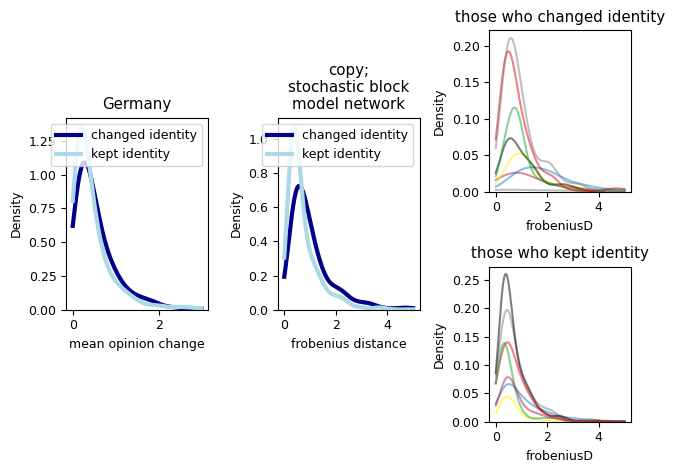

In [59]:
fig, axs= plt.subplot_mosaic([["a","a", "change"],["cmpOp", "cmp", "change"], ["cmpOp", "cmp", "keep"], ["b", "b", "keep"]], sharex=False, sharey=False, gridspec_kw=dict(height_ratios = [0.2,1.2,0.7,0.6], width_ratios=[1,1,1]))

sns.kdeplot(diff.loc[diff.identity_changed], x="frobeniusD", hue="identity_after", palette=partyColsDict[country], alpha=0.5, ax=axs["change"], clip=(0,5), legend=False)
sns.kdeplot(diff.loc[~diff.identity_changed], x="frobeniusD", hue="identity_after", palette=partyColsDict[country], alpha=0.5, ls="-", ax=axs["keep"], legend=False, clip=(0,5))
for ax in ["a", "b"]: 
    axs[ax].axis(False)
ax2 = axs["cmp"]
sns.kdeplot(diff.loc[diff.identity_changed], x="frobeniusD", lw=3, alpha=1, ax=ax2, color="darkblue", clip=(0,5), label="changed identity")
sns.kdeplot(diff.loc[~diff.identity_changed], x="frobeniusD", lw=3, alpha=1, ax=ax2, color="lightblue", clip=(0,5), label="kept identity")
axs["cmp"].legend()
axs["cmp"].set_xlabel("frobenius distance")
nstr = "no network" if n == "observe-all" else "stochastic block\nmodel network"
axs["cmp"].set_title(f"{i};\n{nstr}")

ax2 = axs["cmpOp"]
sns.kdeplot(diff.loc[diff.identity_changed], x="op_change", lw=3, alpha=1, ax=ax2, color="darkblue", clip=(0,3), label="changed identity")
sns.kdeplot(diff.loc[~diff.identity_changed], x="op_change", lw=3, alpha=1, ax=ax2, color="lightblue", clip=(0,3), label="kept identity")
axs["cmpOp"].legend()
axs["cmpOp"].set_xlabel("mean opinion change")
axs["cmpOp"].set_title(f"{country}")

axs["change"].set_title("those who changed identity")
axs["keep"].set_title("those who kept identity")
fig.tight_layout()


In [61]:
coherence?

Signature: coherence(df, atts)
Docstring: <no docstring>
File:      ~/csh-research/projects/adaptive-belief-networks/code/help_functions.py
Type:      function

In [ ]:
diff["coherence"] = diff.apply(lambda x: coherence(x, atts), axis=1 )

KeyError: 'econ'

In [27]:
import plotly.graph_objects as go
flows = (
    diff#[df['identity_before'] != df['identity_after']]
    .groupby(['identity_before', 'identity_after'])
    .size()
    .reset_index(name='count')
)
flows['source_label'] = flows['identity_before'] + ' (before)'
flows['target_label'] = flows['identity_after'] + ' (after)'

all_nodes = pd.unique(flows[['source_label', 'target_label']].values.ravel())
node_indices = {label: i for i, label in enumerate(all_nodes)}
source = flows['source_label'].map(node_indices)
target = flows['target_label'].map(node_indices)
value = flows['count']

node_colors = []
for label in all_nodes:
    party_name = label.replace(' (before)', '').replace(' (after)', '')
    color = partyColsDict[country].get(party_name, '#aaaaaa')  # fallback-farbe
    node_colors.append(color)

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        label=list(all_nodes),
        pad=15,
        thickness=20,
        color=node_colors 
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])

fig.update_layout(title_text="Identity switch ", font_size=12)
fig.show()


# Including Belief changes + Network change

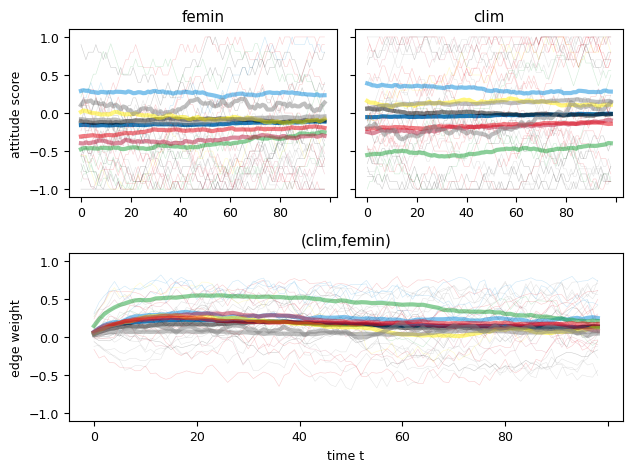

In [39]:
fig, axs = plt.subplot_mosaic([["a", "b"], ["c","c"]], sharey=True)
seed = 5
T = 1
jump =0.1
eps, mu, lam = (0.4,0.2,0.05)
dataset = "gesis"
n_ag = 1000
infl = "copy"
country = countryXdataset[dataset]
atts = atts_datasets[dataset]
w = waves[dataset][1]
edgeNamesTuple = [f"({i},{j})" for i,j in list(combinations(atts, 2))]
edgeNames = [f"{e.split(',')[0][1:]}↔{e.split(",")[1][:-1]}" for e in edgeNamesTuple]
fname = f"results/inferBNs+BeliefChange-dynamic_{dataset}-n-{n_ag}_{infl}-{n}beliefJump-{jump}-T{T}_{w}-{country}_eps{eps}_mu{mu}_lam{lam}_seed{seed}"

sim = pd.read_csv(fname+".csv")

i, j = ("femin", "clim") #("euth", "asyl") # ("asyl", "eu")
e = f"({i},{j})" if f"({i},{j})" in edgeNamesTuple else f"({j},{i})"
for ax, e in zip(["a", "b", "c"], [i, j, e]) :
    a = plot_results_over_time(fname, sim, sim["index"],  e, partyColsDict, country, ax=axs[ax])
    axs[ax].set_xlabel("")
axs["c"].set_xlabel("time t")
axs["c"].set_ylabel("edge weight")
axs["a"].set_ylabel("attitude score")
#fig.suptitle(f"{country}, waves {w}, {infl}, {nstr}, n={n_ag}, Temp={T}, belief_jump={jump}", fontsize=bigfs)
fig.tight_layout()


# VISULASISE INDIVIDUAL BELIEF NETWORKS

In [29]:
# example = np.random.choice(before.index)
# att = (eps, mu, lam, dataset.upper(), country, waves[dataset][0])

# bn_adj, edges = get_bn(before.loc[[example, example]].loc[:], edgeNamesTuple)
# G = nx.from_pandas_edgelist(edges, source='source', target='target', edge_attr='weight', create_using=nx.Graph())
# fig, ax = plt.subplots(1,1, figsize=(7/2.54, 4/2.54))
# ax = plot_network(ax, G, bn_adj, "geometric", minEdgeLen=0.005, scaleE=10)
# fig.tight_layout()
# #plt.savefig(f"bn_before{example}.png", dpi=600)



# bn_adj, edges = get_bn(after.loc[[example, example]].loc[:], cutoff=0.005)
# G = nx.from_pandas_edgelist(edges, source='source', target='target', edge_attr='weight', create_using=nx.Graph())
# fig, ax = plt.subplots(1,1, figsize=(7/2.54, 4/2.54))
# ax = plot_network(ax, G, bn_adj, "geometric", minEdgeLen=0.005, scaleE=10)
# fig.tight_layout()
# #plt.savefig(f"figs_panelLISS/bn_after{example}.png", dpi=600)

# # att = (eps, mu, lam, dataset.upper(), country, waves[1])
# # fig, axs, G = plotResults_average(after.loc[[example, example]], (eps, mu, lam), wave=waves[1], posOption="geometric", country=country, scaleE=5)

# # #axs[0].set_title(f"Simulated BN,Individual {example} ({simOut[att].loc[example, 'identity']}), waves {waves[1]}")
# # fig.suptitle("")
# # plt.savefig("bn_after.pdf", dpi=600)

## Opinion change

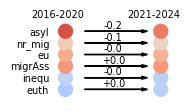

In [33]:
example = before.sample().index.values[0]

fig, ax = plt.subplots(1,1,figsize=(5/2.54, 3/2.54))

ys = np.arange(len(atts))*0.2
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
plt.scatter(y=ys, x=[1]*len(atts), c=before.loc[example, atts].values, cmap="coolwarm", norm=norm, s=100)
plt.scatter(y=ys, x=[1.5]*len(atts), c=after.loc[example, atts].values, cmap="coolwarm", norm=norm, s=100)
ax.set_yticks(ys)
#ax.set_yticklabels([shortcuts[a] for a in atts], fontsize=smallfs)
ax.set_yticklabels(atts, fontsize=smallfs)
for n, att in zip(ys, atts):
    ax.arrow(1.1, n, 0.3, 0, head_width = 0.05, head_length=0.03, color="k")
    d =(after.loc[example, att]-before.loc[example, att])
    ax.text(1.1+0.3/2, n+0.012, f"{('+' if d>=0 else '-')}{abs(d):.1f}", va="bottom", ha="center", fontsize=smallfs, )
for sp in ax.spines:
    ax.spines[sp].set_visible(False)
ax.set_xlim(0.94,1.6)
ax.set_ylim(ys[0]-np.diff(ys)[0],ys[-1]+3*np.diff(ys)[0]/2)
ax.text(1.1,ys[-1]+np.diff(ys)[0], yearsXdatasetXwaves[dataset][waves[dataset][0]],va="bottom",ha="right", fontsize=smallfs)
ax.text(1.6,ys[-1]+np.diff(ys)[0], yearsXdatasetXwaves[dataset][waves[dataset][1]],va="bottom", ha="right", fontsize=smallfs)
ax.set_xticks([])
ax.yaxis.set_tick_params(which="both", length=0)
fig.tight_layout()
#plt.savefig(f"figs_panelLISS/beliefchange_individ{example}.png", dpi=600, bbox_inches="tight")
plt.savefig("testfigs/bns.png", dpi=600)    

## BN

In [31]:
def get_bnSingle(si):
    A = pd.DataFrame(np.zeros((len(atts), len(atts))), index=atts, columns=atts)
    for atti, attj in list(combinations(atts, 2)):
        A.loc[atti, attj] = si[f"({atti},{attj})"]
        A.loc[attj, atti] = si[f"({atti},{attj})"]
    return A


In [32]:
a = get_bnSingle(before.loc[example])
a

econ      migr     assim      clim      euro     femin
econ   0.000000  0.358996 -0.462423  0.655256  0.356665  0.256726
migr   0.358996  0.000000  0.180230  0.471863  0.379921  0.176328
assim -0.462423  0.180230  0.000000 -0.404692 -0.258540 -0.111664
clim   0.655256  0.471863 -0.404692  0.000000  0.556852  0.477830
euro   0.356665  0.379921 -0.258540  0.556852  0.000000  0.316324
femin  0.256726  0.176328 -0.111664  0.477830  0.316324  0.000000

#### coherence

In [33]:
print("before: ", coherence(before.loc[[example, example]], atts)["coherence"].iloc[0], 
      "after: ", coherence(after.loc[[example, example]], atts)["coherence"].iloc[0])

before:  1.967940712148867 after:  3.8952863061363914


In [34]:
coherence(before, atts)["coherence"].mean(), coherence(after, atts)["coherence"].mean()

(np.float64(1.4693898284286993), np.float64(1.7802557767199896))

In [35]:
for p in partiesDict[country]:
    print(p, coherence(before.loc[before.identity==p], atts)["coherence"].mean(), coherence(after.loc[after.identity==p], atts)["coherence"].mean())

Linke 1.8571150611359144 1.9795625164464559
Grüne 1.4142994924061723 1.6740135933341642
SPD 1.1394618697734995 1.1730514736213717
FDP 1.1721014492378024 1.7106927613287937
CDU/CSU 0.9998809312792716 1.3105661207854302
AfD 3.3691044454546644 4.318372026277493
none 1.325967768495647 1.566176338556527


/home/steiglechner/csh-research/projects/adaptive-belief-networks/code/help_functions.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: ylabel='coherence'>

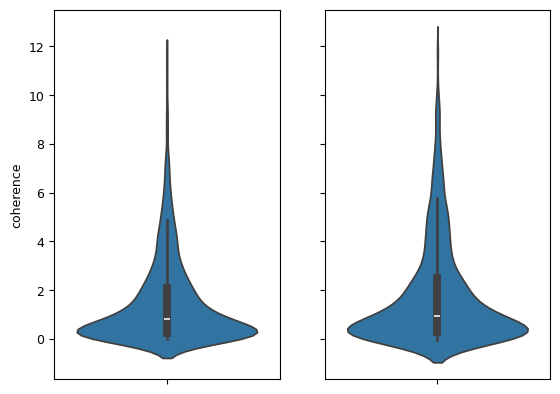

In [36]:
fig, axs = plt.subplots(1,2, sharey=True)
sns.violinplot(coherence(before, atts)["coherence"], ax=axs[0]) 
sns.violinplot(coherence(after, atts)["coherence"], ax=axs[1])

# Network distances

In [ ]:

def spectral_distance(A1, A2, k=None):
    """
    Computes the spectral distance between two weighted graphs based on their adjacency matrices.

    Parameters:
    - G1, G2: networkx.Graph (weighted graphs)
    - k: Number of eigenvalues to compare (default: all)

    Returns:
    - Spectral distance (sum of absolute differences of eigenvalues)
    """
    # Convert graphs to weighted adjacency matrices
    #A1 = nx.to_numpy_array(G1)
    #A2 = nx.to_numpy_array(G2)
    eigvals1 = np.linalg.eigvalsh(A1)  # Sorted automatically
    eigvals2 = np.linalg.eigvalsh(A2)
    assert (len(eigvals1)== len(eigvals2))
    if k is not None:
        eigvals1 = eigvals1[-k:]
        eigvals2 = eigvals2[-k:]
    spectral_dist = np.sum(np.abs(eigvals1 - eigvals2))
    return spectral_dist


def frobenius_distance(A1, A2):
    """
    Compute the Frobenius norm between two weighted adjacency matrices.
    
    Parameters:
    A1, A2: numpy arrays of shape (n,n) representing weighted adjacency matrices
    
    Returns:
    float: The Frobenius distance between the networks
    """
    return np.linalg.norm(A1 - A2, 'fro')



In [81]:
distancesS = []
for i in indices_before_after:
    distancesS.append(spectral_distance(get_bnSingle(before.loc[i]), get_bnSingle(after.loc[i])))

In [78]:
distances = []
for i in indices_before_after:
    distances.append(frobenius_distance(get_bnSingle(before.loc[i]), get_bnSingle(after.loc[i])))

In [90]:
alld = pd.DataFrame([pd.Series(distances, index=indices_before_after, name="frobenius"), pd.Series(distancesS, index=indices_before_after, name="spectral")]).T

In [91]:
alld["partyIdentBC"] = before.loc[indices_before_after]["identity"]
alld["partyIdentAC"] = after.loc[indices_before_after]["identity"]
alld["sameParty"] = after.loc[indices_before_after]["identity"] == before.loc[indices_before_after]["identity"]

In [92]:
alld

frobenius  spectral partyIdentBC partyIdentAC  sameParty
2       0.248174  0.382836        Grüne        Grüne       True
5       0.195444  0.272555      CDU/CSU         none      False
6       0.334556  0.164783         none         none       True
7       0.370739  0.587181         none          FDP      False
11      0.322843  0.256954         none          FDP      False
...          ...       ...          ...          ...        ...
41311   0.153298  0.137657          AfD          AfD       True
41313   0.295490  0.214263      CDU/CSU          NaN      False
41321   0.871868  0.670288      CDU/CSU      CDU/CSU       True
41327   0.359876  0.361598      CDU/CSU          SPD      False
41328   0.377436  0.403120        Linke        Linke       True

[14356 rows x 5 columns]

(0.0, 2.9773657752278475)

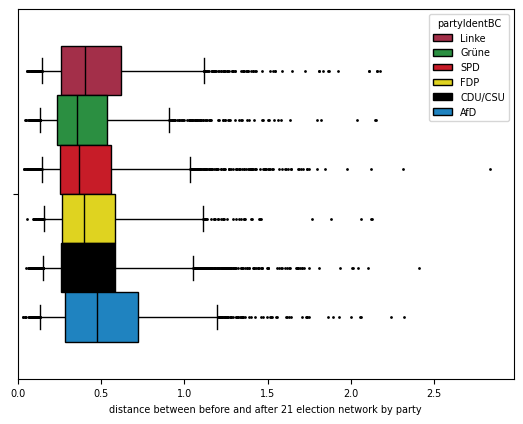

In [ ]:
sns.boxplot(alld.loc[alld.partyIdentBC.isin(partiesDict[country])], x="spectral", hue="partyIdentBC", whis=[5,95], fliersize=1,palette=partiesDict[country], hue_order=partiesDict[country])
plt.xlabel("distance between before and after 21 election network by party")
plt.xlim(0,)

# Archive


In [ ]:

# i = "copy"
# #n = "observe-neighbours(Stoch-Block-10-0)"
# dataset = "liss"
# atts = atts_datasets[dataset]
# country = countryXdataset[dataset]
# fig, axs = plt.subplots(2,1, figsize=(19/2.54, 12/2.54), sharex=True)
# for ax, w in zip(axs, waves[dataset]):
#     df = simOut[(eps, mu, lam, i, n, n_ag, dataset, country, w, seed)]# Melt the DataFrame to long format
#     df_melted = df.melt(id_vars="identity", value_vars=atts,
#                         var_name='attitude', value_name='value')


#     sns.boxplot(data=df_melted, x='identity', y='value', hue='attitude', palette='Set2', dodge=True,  fliersize=0.2, order=parties[country], ax=ax, legend=True if ax==axs[0] else False)
#     sns.pointplot(
#         data=df_melted,
#         x='identity', y='value', hue='attitude',
#         estimator='mean', dodge=0.67, linestyles="", markers='D', palette='dark:black', errorbar=None, ax=ax, legend=False,  order=parties[country], markersize=1
#     )

#     # Add title and labels
#     ax.set_title(f'{country}, waves {w} with {n_ag} agents', fontsize=bigfs)
#     ax.set_xlabel('Identity Group')
#     ax.set_ylabel('Attitude Score')
#     if ax==axs[1] and not "all" in n: ax.text(1.02, 1, f"network:   {n.split('(')[0]}\n                 {n.split('(')[1][:-1]}"+"\n\n"+f"influence:   {i}", rotation=90, ha="left", va="top", transform=ax.transAxes, fontsize=smallfs)
#     if ax==axs[0]: ax.legend(title='Attitude', bbox_to_anchor=(1.02, 1), loc='upper left')
# fig.tight_layout()
# plt.show()


#sns.stripplot(pd.melt(df.groupby("identity")[atts].mean().reset_index(), id_vars=["identity"]), jitter=0, y="value", x="identity", hue="variable", order=parties[country], marker="D")
